## ISS projekt - piano
xjirmu00
Jirmusová Veronika
VUT FIT 2022

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interactive, fixed, IntSlider


from PIL import Image
from matplotlib.patches import Rectangle

import scipy.signal as ss
import soundfile as sf
from IPython.display import display
from IPython.display import Audio

## 1 Vzorek siglálů

Signály byly navzorkované pomocí kódu pana profesora, který byl v zadání, do kterého bylo poté pouze doplněno vykreslování do grafů. Audio bylo vytvořrno pomocí funkce sf.write().

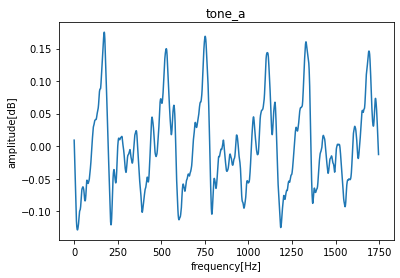

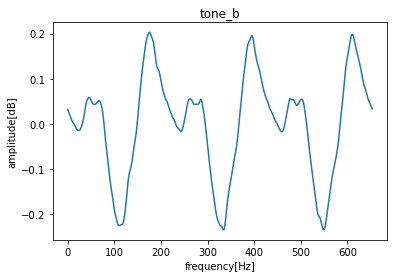

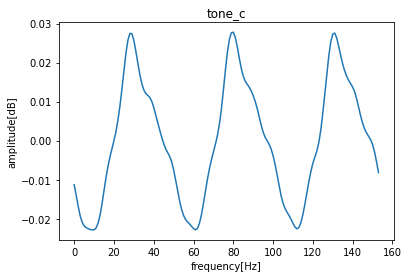

In [33]:
MIDIFROM = 24                   
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read("klavir.wav")
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N))  # matrix with all tones - first signals empty,
                                # but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N

for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone
    

#sf.write("a_orig.wav", xall[40], Fs)
#sf.write("b_orig.wav", xall[57], Fs)
#sf.write("c_orig.wav", xall[82], Fs)
plt.plot(xall[40][0:int(3*Fs//82.41)]) #tone a - MIDI 40, Frq 82.41
plt.title("tone_a")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()
plt.plot(xall[57][0:int(3*Fs//220.00)]) #tone b - MIDI 57, Frq 220.00
plt.title("tone_b")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()
plt.plot(xall[82][0:int(3*Fs//932.33)]) #tone c - MIDI 82, Frq 932.33
plt.title("tone_c")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()



##  DFT 
DFT se tvoří pomocí funkce np.fft.fft(), díky čemuž můžeme vytvořit graf DFT. Vykreslují se nám ale imaginární složky na reálné ose, proto bylo potřeba aplikovat absolutní hodnotu na tyto hodnoty, abych se problému zbavila (inspirace z notebooku 02 pana profesora). Tyto hodnoty je poté potřeba 'rozpůlit' pro lepší vizualizaci. Funkce plt.figure() určí velikost grafu v palcích a do něj pak vykresluji výsledné DFT.

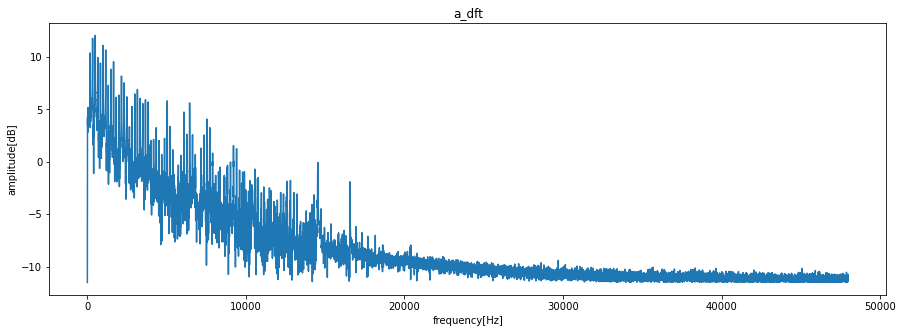

In [34]:
#tone_a
a_dft = xall[40]
a_dft = np.fft.fft(a_dft)
a_dft = np.abs(a_dft)
a_dft = a_dft[:a_dft.size//2]
idk = np.arange(a_dft.size)*Fs / (a_dft.size)
idklog = np.log(a_dft**2 + (10**-5))

plt.figure(figsize=(15,5))

plt.plot(idk, idklog)
plt.title("a_dft")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()

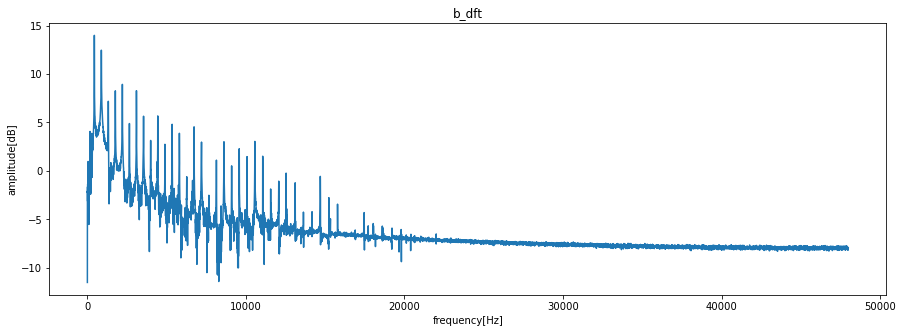

In [35]:
#tone_b
b_dft = xall[57]
b_dft = np.fft.fft(b_dft)
b_dft = np.abs(b_dft)
b_dft = b_dft[:b_dft.size//2]
idklog = np.log(b_dft**2 + (10**-5))

plt.figure(figsize=(15,5))

plt.plot(idk, idklog)
plt.title("b_dft")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()

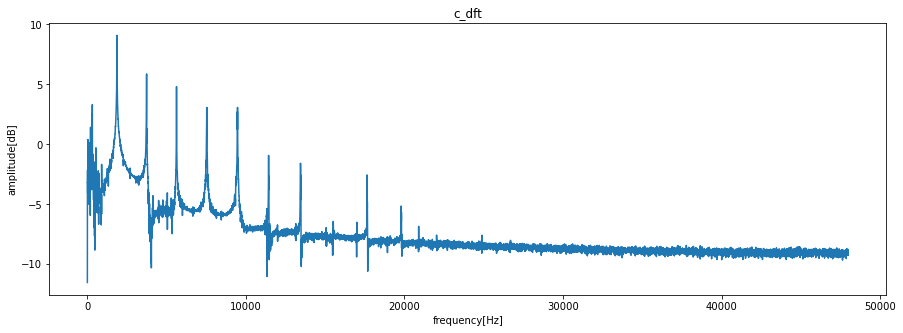

In [36]:
#tone_c
c_dft = xall[82]
c_dft = np.fft.fft(c_dft)
c_dft = np.abs(c_dft)
c_dft = c_dft[:c_dft.size//2]
idklog = np.log(c_dft**2 + (10**-5))

plt.figure(figsize=(15,5))

plt.plot(idk, idklog)
plt.title("c_dft")
plt.xlabel("frequency[Hz]")
plt.ylabel("amplitude[dB]")
plt.show()

## 2. Autokorelace + DFT
Dále byla provedena autokorelace pro MIDI 24 - 41 a DTF pro vyšší MIDI z toho důvodu, že autokorelace funguje přesněji pro nižší frekvence a DFT naopak. Jednotlivé frekvence jsem počítala tak, že jsem zavolala funkci np.correlate() v módu 'full' a odečetla jsem druhý největší 'peak' od největšího a to jsem následně vynásobila vzorkovací frekvencí Fs. Frekvence se lehce liší od stanovené frekvence a to zejména z důvodu podladění klavíru o přibližně 1/32 tónu.
Výsledek generace těchto frekvencí se nachází v souboru dft_autocorr.txt, popř. po odkomentání funkce print() pod buňkou s kódem DFT.

In [ ]:
#autokorelace
i = 24
f0 = np.zeros(MIDITO+1)
for tone in xall[i:41]:
    autocorr = np.correlate(tone, tone, mode = 'full')
    autocorr = autocorr[autocorr.size//2-1:]
    b1 = ss.find_peaks(autocorr, max(autocorr)//1.4)[0][0]
    b2 = ss.find_peaks(autocorr, max(autocorr)//1.4)[0][1]
    f0[i] = 1/(b2-b1)*Fs

    #print(i, Fs/(b2-b1), file=open("output.txt", 'a'))
    i += 1



In [ ]:
#dft
i = 41
for tone in xall[41:]:
    idkman = np.fft.fft(tone)
    fuf = (np.arange(idkman.size)*Fs / (idkman.size))[np.argmax(np.abs(idkman[:idkman.size//2]))]
    #print(i, fuf)  #pro výpis odkomentovat
    f0[i] = fuf
    i += 1
    

#### Vykreslení autokorelace pro tón a - MIDI 40:

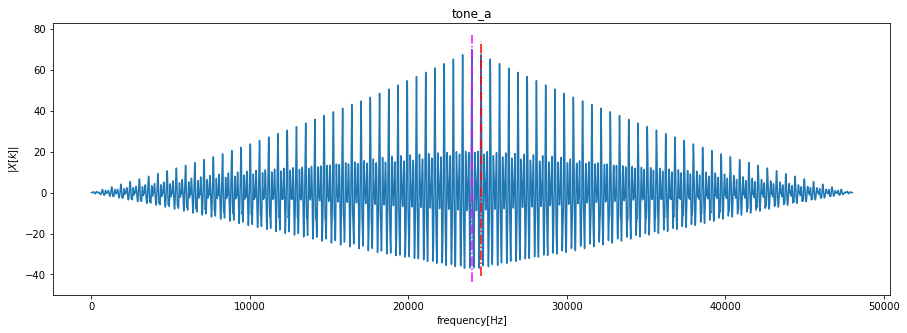

In [37]:
tone = xall[40]
autocorr = np.correlate(tone, tone, mode = 'full')
plt.figure(figsize=(15,5))
plt.plot(autocorr)
autocorr_halb = autocorr[autocorr.size//2-1:]
b1 = ss.find_peaks(autocorr_halb, max(autocorr_halb)//1.4)[0][0]
b2 = ss.find_peaks(autocorr_halb, max(autocorr_halb)//1.4)[0][1]
plt.vlines(b1+autocorr.size//2-1, min(autocorr)-7, max(autocorr)+7, colors="magenta", linestyles="dashdot")
plt.vlines(b2+autocorr.size//2-1, min(autocorr)-4, max(autocorr)+4, colors="red", linestyles="dashdot")
plt.title("tone_a")
plt.xlabel("frequency[Hz]")
plt.ylabel('$|X[k]|$')
plt.show()

#### Vykreslení DFT pro tóny b, c - MIDI 57 a 82

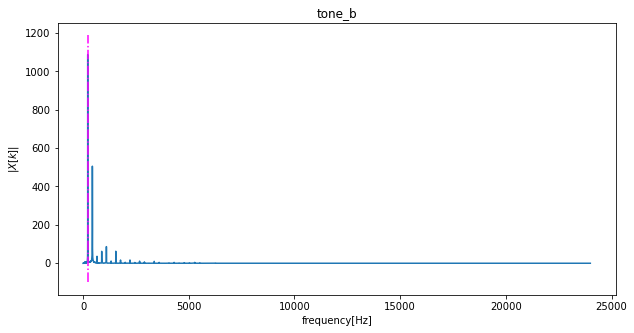

In [38]:

tone = xall[57]
tone_dft = np.fft.fft(tone)
tone_dft = np.abs(tone_dft)
tone_dft = tone_dft[:tone_dft.size//2]
idk = np.arange(tone_dft.size)*Fs / (tone.size)
fuf = (np.arange(tone.size)*Fs / (tone.size))[np.argmax(tone_dft)]

plt.figure(figsize=(10,5))

plt.plot(idk, tone_dft)
plt.vlines(fuf, -100, max(tone_dft)+100, colors="magenta", linestyles="dashdot")
plt.title("tone_b")
plt.xlabel("frequency[Hz]")
plt.ylabel('$|X[k]|$')
plt.show()

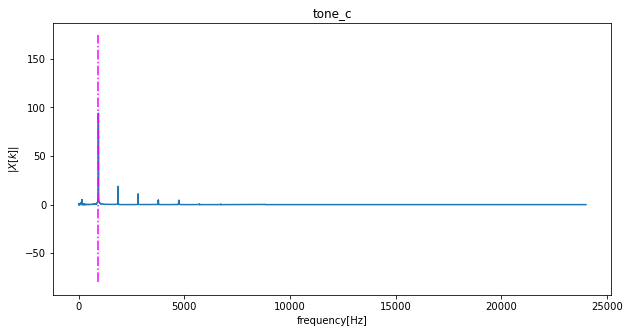

In [39]:
tone = xall[82]
tone_dft = np.fft.fft(tone)
tone_dft = np.abs(tone_dft)
tone_dft = tone_dft[:tone_dft.size//2]
idk = np.arange(tone_dft.size)*Fs / (tone.size)
fuf = (np.arange(tone.size)*Fs / (tone.size))[np.argmax(tone_dft)]

plt.figure(figsize=(10,5))

plt.plot(idk, tone_dft)
plt.vlines(fuf, -80, max(tone_dft)+80, colors="magenta", linestyles="dashdot")
plt.title("tone_c")
plt.xlabel("frequency[Hz]")
plt.ylabel('$|X[k]|$')
plt.show()

## 3. DTFT 
Při psaní této čáati jsem se primárně inspirovala opět ve druhém notebooku pana profesora. DTFT spočívá v obecném zpřesnění výpočtu frekvence, která se již začala blížit zadané frekvenci, není však 100% z důvodu podlazení klavíru. Výpis se nachází v souboru dtft.txt nebo pod buňkou po odkomentání výpisu. 
Použitý vzorec: A = e^(-j*2pi*k*n/N)

In [40]:
#DTFT 
for i in range (MIDIFROM, MIDITO + 1, 1):
    tone = xall[i,:]

    RANGE = 5
    FREQPOINTS = 1000
    f = f0[i]


    n = np.arange(0, tone.size)
    A = np.zeros([int(RANGE*2/0.01)+1, tone.size],dtype=complex)   
    q = 0
    for k in np.arange(f - RANGE, f + RANGE, 0.01):
        A[q,:] = np.exp(-1j * 2 * np.pi * k * (n/tone.size))  
        q += 1 # norm. omega = 2 * pi * f / Fs ... 
        #cos = np.matmul(np.cos(2*np.pi*k*(n/N)), xall[tone,:].T)
        #sin = np.matmul(np.sin(2*np.pi*k*(n/N)), xall[tone,:].T)
        
    Xdtft = np.matmul(A, tone.T)


    #plt.plot(np.arange(f - RANGE, f + RANGE, 0.01), np.abs(Xdtft))
    #plt.show()

    dtft = np.abs(Xdtft)
    #d1 = ss.find_peaks(dtft[dtft.size//2:], max(dtft[dtft.size//1.85:])//1.85)[0][0]
    #d2 = ss.find_peaks(dtft[dtft.size//2:], max(dtft[dtft.size//1.85:])//1.85)[0][1]
    #print(f)
    precisefmax = np.arange(f - RANGE, f + RANGE, 0.01)[np.argmax(np.abs(Xdtft))]
    #print(i, precisefmax)  #odkomentovat pro výpis

